In [480]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error

import math

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

import patsy

In [481]:
# Current script
current_path = os.getcwd()

# Add utils folder to sys path 
sys.path.append(os.path.join(current_path, "utils"))

# Import the prewritten helper functions
from py_helper_functions import *

# DATA

In [482]:
# Read the data
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/DA3-Assignment-3/main/cs_bisnode_panel.csv")


data = data.query("year != 2016")
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

# Label Engineering

In [483]:
pd.set_option("float_format", "{:.5f}".format)

In [484]:
#Alive in 2014: sales is positive (>0) and not NA, in 2014
data["status_alive2014"] = ((data["sales"] > 0) & (data["sales"].isna() == False) & (data["year"] == 2014)).astype(int)

#Alive in 2015: sales is positive (>0) and not NA, in 2015
data["status_alive2015"] = ((data["sales"] > 0) & (data["sales"].isna() == False) & (data["year"] == 2015)).astype(int)

In [485]:
#Your definition of default should be the following:
# – Existed in 2014 (sales > 0)(status_alive2014 is 1), but did not exists in 2015 (sales is 0 or missing)(status_alive2015 is not 1)
data["default"] = ((data["status_alive2014"] == 1) & (data.groupby("comp_id")["status_alive2015"].shift(-1) != 1)).astype(int)

In [486]:
data = data.query("year >= 2014")

In [487]:
# drop variables with many NAs
data = data.drop(
   columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)

In [488]:
# less than 10mil sales
data = data.loc[data["sales"] < 10000000]

In [489]:
# change negative sales values into 1
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"])

In [490]:
# Create log sales, sales in millions, log sales in million

data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [491]:
# 1 year difference in log sales million
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)

In [492]:
# replace age 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)

data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

In [493]:
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)

data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

# Feature Engineering

In [494]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [495]:
# Firm characteristics
# age squared
data["age2"] = data["age"] ** 2

# foreign management if more than 50% is foreign
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)

# to category
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [496]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.00000    54980
1.00000       27
Name: comp_id, dtype: int64

In [497]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [498]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count       55007.00000
mean       258560.30749
std       2738598.77567
min             0.00000
25%          5214.81485
50%         20225.92676
75%         87288.89026
max     319069129.03125
Name: total_assets_bs, dtype: float64

In [499]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [500]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [501]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

In [502]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [503]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [504]:
data = data.drop(["labor_avg"], axis=1)

In [505]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])

In [506]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

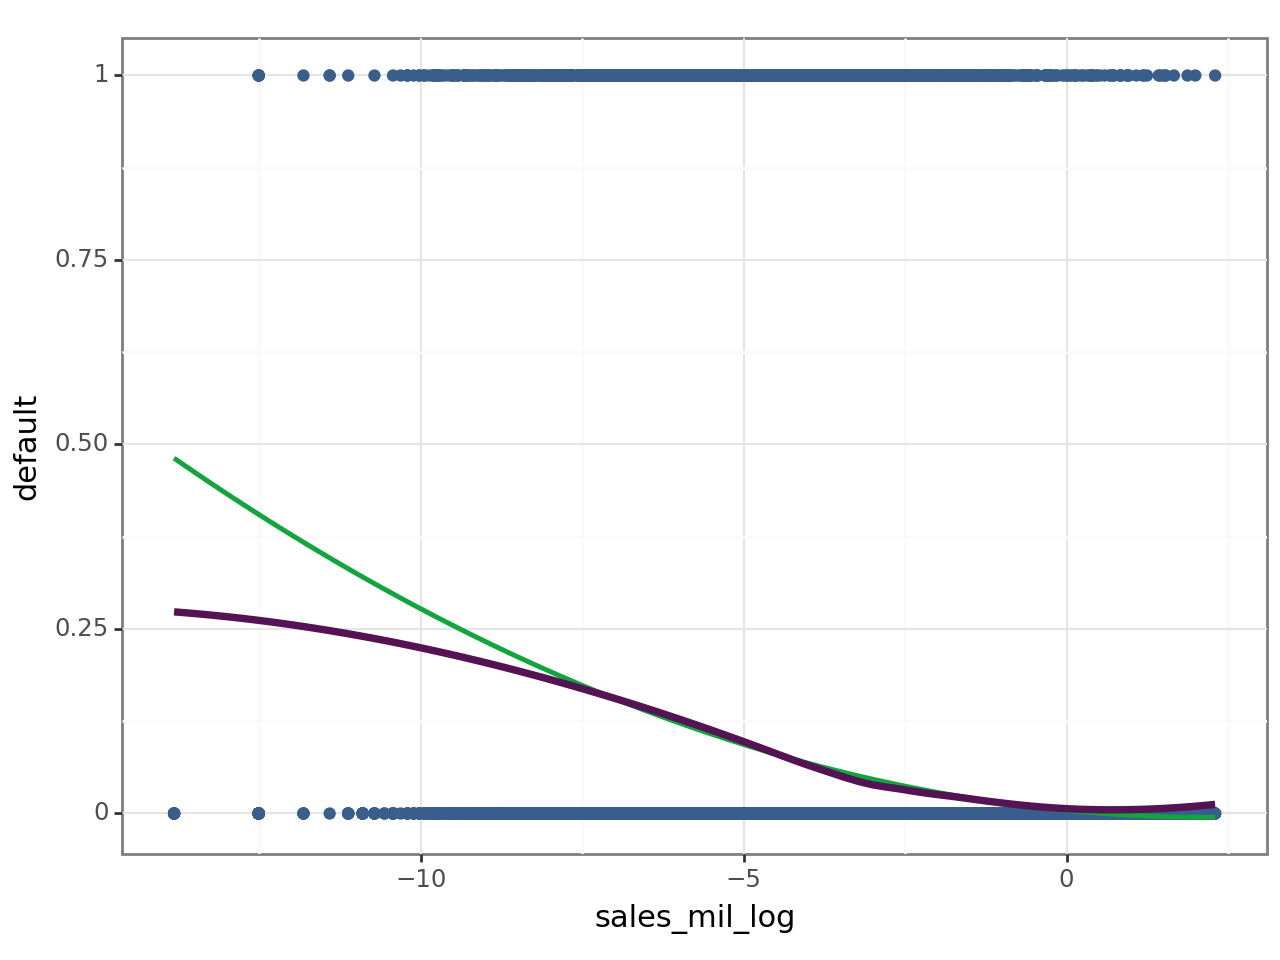

<Figure Size: (640 x 480)>

In [507]:
(
    ggplot(data, aes(x="sales_mil_log", y="default"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="default")
    + theme_bw()
)

In [508]:
# Linear regressions
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1306.
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        19:01:24   Log-Likelihood:                 10171.
No. Observations:               55027   AIC:                        -2.034e+04
Df Residuals:                   55024   BIC:                        -2.031e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0042      0.001  

In [509]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()

count   55027.00000
mean        0.04591
std         0.99720
min       -12.50618
25%         0.00000
50%         0.00000
75%         0.00000
max        13.81551
Name: d1_sales_mil_log, dtype: float64

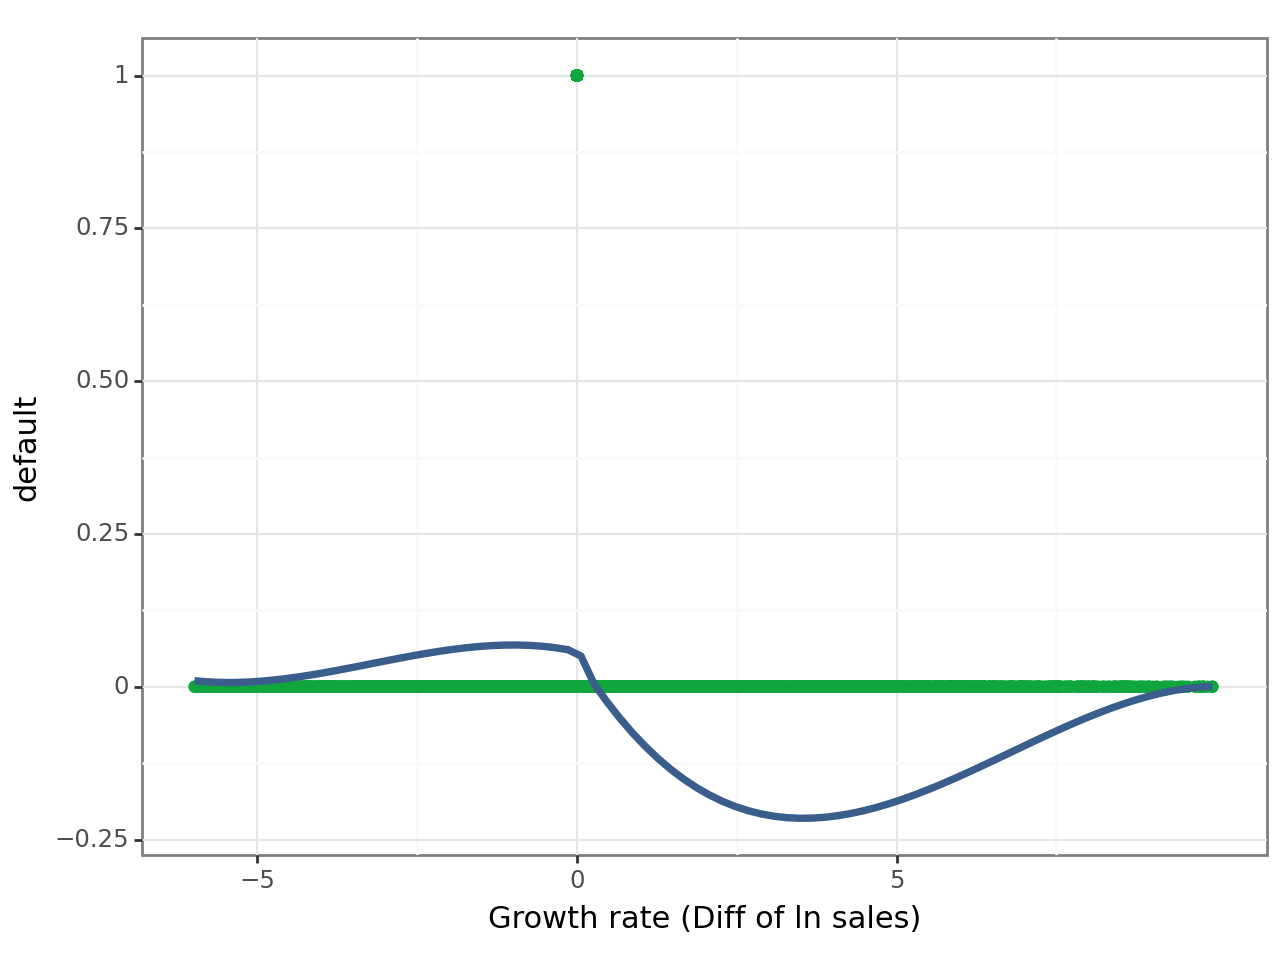

<Figure Size: (640 x 480)>

In [510]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-6, 10), breaks=seq(-5, 10, by=5))
    + theme_bw()
)

In [511]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

In [512]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

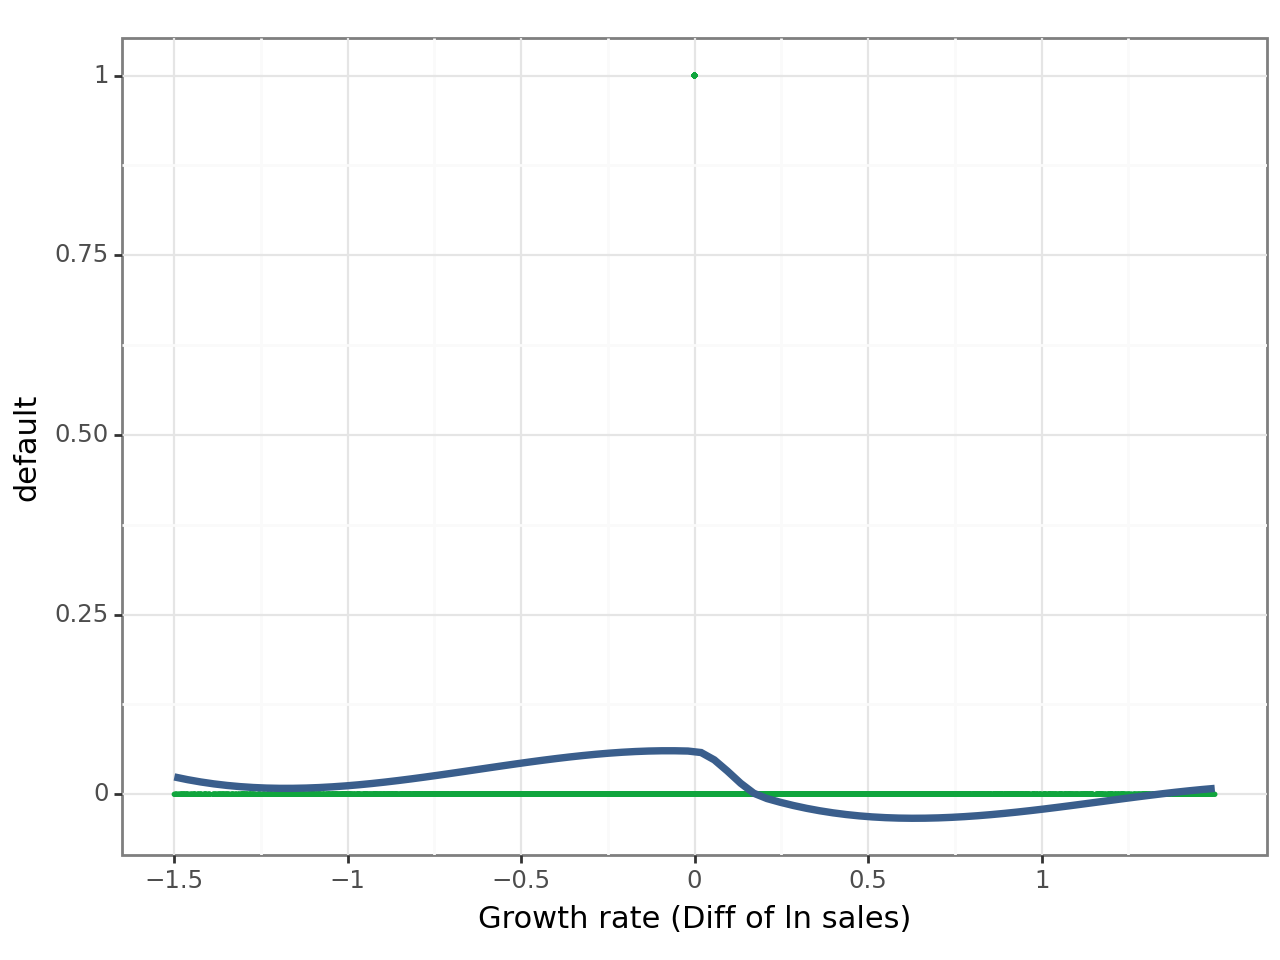

<Figure Size: (640 x 480)>

In [513]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=seq(-1.5, 1.5, by=0.5))
    + theme_bw()
)

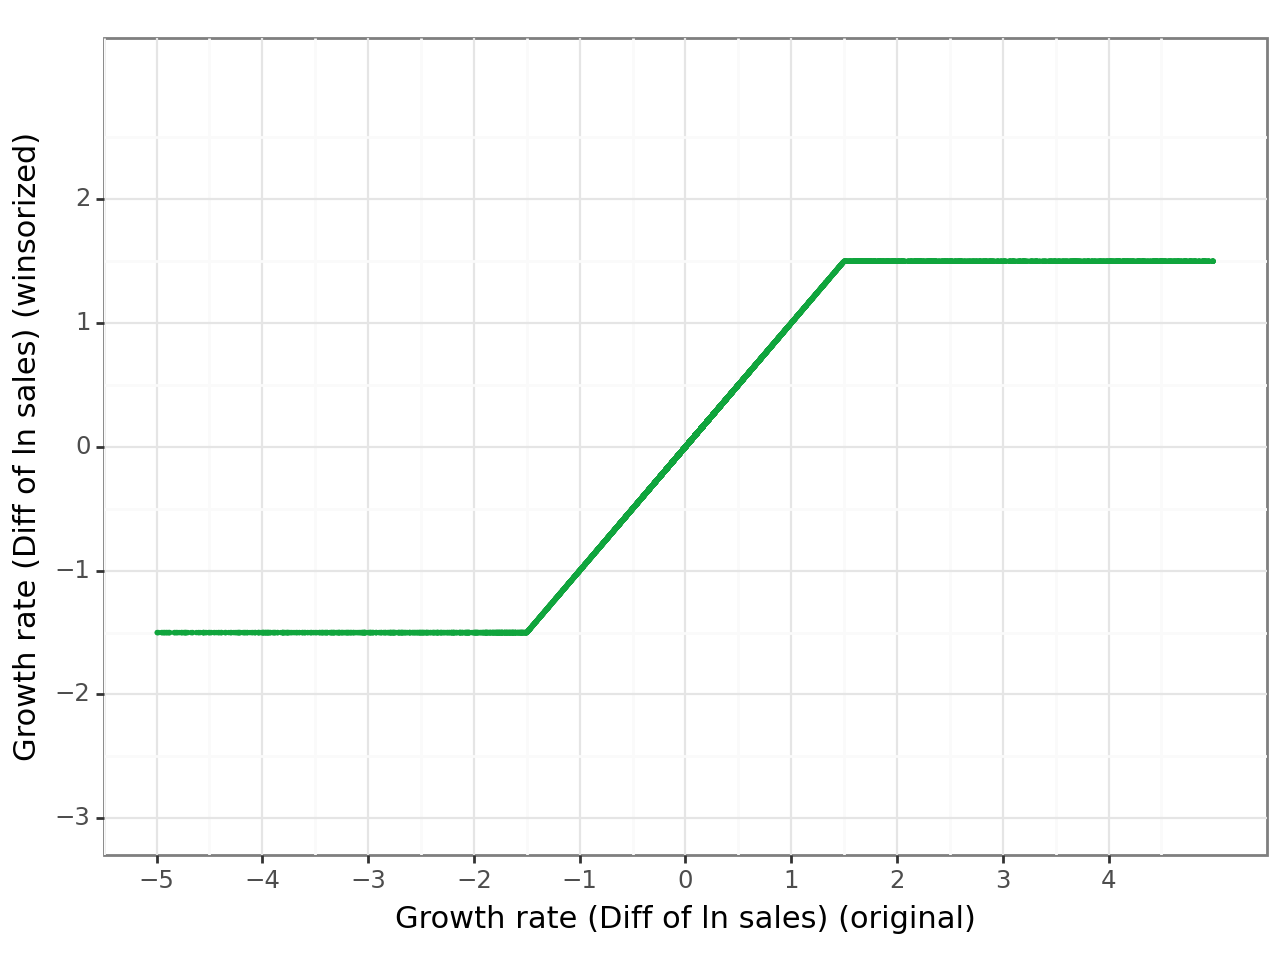

<Figure Size: (640 x 480)>

In [514]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=seq(-5, 5, by=1))
    + scale_y_continuous(limits=(-3, 3), breaks=seq(-3, 3, by=1))
    + theme_bw()
)

In [515]:
# Fill NAs
f = [c for c in data.columns if c not in ["gender_m","m_region_loc","urban_m","default_f"]]
data[f] = data[f].fillna(0)
data[f] = data[f].round(3)

# Holdout Sample

In [516]:
data_holdout = data

# Existed in 2014 (sales > 0), but did not exists in 2015 (sales is 0 or missing)
Exist14 = data.loc[(data["year"] == 2014) & (data["sales"] > 0)]
Exist15 = data.loc[(data["year"] == 2015) & (data["sales"].isin([0, np.nan]))]

data_holdout = Exist14[~Exist14.index.isin(Exist15.index)]

# between 1000 and 10 million
data_holdout = data_holdout.loc[(data_holdout["sales"] > 1000) & (data_holdout["sales"] < 10000000)]

# ind2 == 26
data_holdout = data_holdout.loc[data_holdout["ind2"] == 26]

data = data[~data.index.isin(data_holdout.index)]

data_holdout["sales"].describe()

count      1037.00000
mean     490202.21793
std     1154087.41431
min        1070.37000
25%       21766.66600
50%       72700.00000
75%      333888.87500
max     9576485.00000
Name: sales, dtype: float64

In [517]:
data_holdout["default"].value_counts()

default
0    981
1     56
Name: count, dtype: int64

In [518]:
data = data.reset_index()
data = data.drop("index", axis = 1)

# Helper Functions

In [519]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

# Variable sets

In [520]:
k = KFold(n_splits = 5, shuffle = True, random_state = 20240205)

In [521]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3 = []
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [522]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")

ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[20.0]'], axis=1)

In [523]:
m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

In [524]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales_mil", "d1_sales_mil_log"] + rawvars + hr + qualityvars]], axis=1)

In [525]:
# Define X1
basevars = data[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)

# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)

# Define X4
X4 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 + engvar2 + hr + qualityvars], firm], axis=1)

In [526]:
# Define X5

#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):d1_sales_mil_log_mod \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", 
                        data, return_type="dataframe")

#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[20.0]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management", 
                        data, return_type="dataframe")

X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [527]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [528]:
y = data['default']

In [529]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=0.8, random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

# Simple linear and logistic models

In [530]:
ols_modelx1 = LinearRegression().fit(X1, y)
regression_results(y, ols_modelx1.predict(X1))

explained_variance:  0.0518
r2:  0.0518
MAE:  0.0834
MSE:  0.04
RMSE:  0.2001


In [531]:
create_coef_matrix(X1, ols_modelx1)

,variable,coefficient
0,sales_mil_log,-0.01102
1,sales_mil_log_sq,0.00166
2,d1_sales_mil_log_mod,0.02011
3,profit_loss_year_pl,-0.02082
4,C(ind2_cat)[26.0],-0.02683
5,C(ind2_cat)[27.0],0.00184
6,C(ind2_cat)[28.0],0.00678
7,C(ind2_cat)[29.0],0.00405
8,C(ind2_cat)[30.0],-0.00593
9,C(ind2_cat)[32.0],-0.00106


In [532]:
glm_modelx1 = LogisticRegression(
    solver="newton-cg",max_iter=1000, penalty="none", random_state = 20240205).fit(X1, y)
regression_results(y, glm_modelx1.predict(X1))

explained_variance:  0.0
r2:  -0.0462
MAE:  0.0442
MSE:  0.0442
RMSE:  0.2101


In [533]:
create_coef_matrix(X1, glm_modelx1)

,variable,coefficient
0,sales_mil_log,-0.78343
1,sales_mil_log_sq,-0.03849
2,d1_sales_mil_log_mod,0.42262
3,profit_loss_year_pl,-0.43561
4,C(ind2_cat)[26.0],-1.47086
5,C(ind2_cat)[27.0],-0.01053
6,C(ind2_cat)[28.0],0.15113
7,C(ind2_cat)[29.0],-0.01975
8,C(ind2_cat)[30.0],-0.20176
9,C(ind2_cat)[32.0],0.05779


In [534]:
glm_modelx2 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X2, y)
regression_results(y, glm_modelx2.predict(X2))

explained_variance:  -0.0008
r2:  -0.0462
MAE:  0.0442
MSE:  0.0442
RMSE:  0.2101


In [535]:
create_coef_matrix(X2, glm_modelx2)

,variable,coefficient
0,sales_mil_log,-0.75419
1,sales_mil_log_sq,-0.03358
2,d1_sales_mil_log_mod,0.39531
3,profit_loss_year_pl,-0.16488
4,C(ind2_cat)[26.0],-1.43497
5,C(ind2_cat)[27.0],0.03809
6,C(ind2_cat)[28.0],0.20867
7,C(ind2_cat)[29.0],-0.02937
8,C(ind2_cat)[30.0],-0.36826
9,C(ind2_cat)[32.0],0.25770


In [536]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
print(mx2.summary())

         Current function value: 0.152371
         Iterations: 35
        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log              -0.0294      0.001    -22.292      0.000      -0.032      -0.027
sales_mil_log_sq           -0.0013      0.000    -10.293      0.000      -0.002      -0.001
d1_sales_mil_log_mod        0.0154      0.002      7.804      0.000       0.012       0.019
profit_loss_year_pl        -0.0064      0.002     -3.384      0.001      -0.010      -0.003
C(ind2_cat)[26.0]          -0.0558      0.022     -2.591      0.010      -0.098      -0.014
C(ind2_cat)[27.0]           0.0015      0.019      0.076      0.939      -0.037       0.040
C(ind2_cat)[28.0]           0.0081      0.019 

In [537]:
glm_modelx3 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X3, y)
regression_results(y, glm_modelx3.predict(X3))

explained_variance:  0.0
r2:  -0.0462
MAE:  0.0442
MSE:  0.0442
RMSE:  0.2101


In [538]:
create_coef_matrix(X3, glm_modelx3)

,variable,coefficient
0,sales_mil_log,0.00000
1,sales_mil_log_sq,-0.00000
2,total_assets_bs,-0.00000
3,fixed_assets_bs,-0.00000
4,liq_assets_bs,-0.00000
5,curr_assets_bs,-0.00000
6,share_eq_bs,-0.00000
7,subscribed_cap_bs,-0.00000
8,intang_assets_bs,-0.00000
9,extra_exp_pl,-0.00000


In [539]:
mx3 = sm.Logit(y,sm.add_constant(X3)).fit().get_margeff()
print(mx3.summary())

         Current function value: 0.130531
         Iterations: 35
        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sales_mil_log                 -0.0275      0.001    -21.580      0.000      -0.030      -0.025
sales_mil_log_sq              -0.0012      0.000     -9.555      0.000      -0.001      -0.001
total_assets_bs             1.593e-09   3.41e-10      4.673      0.000    9.25e-10    2.26e-09
fixed_assets_bs               -0.0501      0.008     -6.255      0.000      -0.066      -0.034
liq_assets_bs                 -0.0101      0.003     -3.208      0.001      -0.016      -0.004
curr_assets_bs                -0.0217      0.008     -2.699      0.007      -0.038      -0.006
share_eq_bs           

In [540]:
ols_model = LinearRegression().fit(X4, y)
regression_results(y, ols_model.predict(X4))

explained_variance:  0.0955
r2:  0.0955
MAE:  0.0912
MSE:  0.0382
RMSE:  0.1954


In [541]:
create_coef_matrix(X4, ols_model)

,variable,coefficient
0,sales_mil_log,-0.01447
1,sales_mil_log_sq,0.00142
2,total_assets_bs,0.00000
3,fixed_assets_bs,-0.04776
4,liq_assets_bs,-0.00990
5,curr_assets_bs,-0.01864
6,share_eq_bs,-0.02012
7,subscribed_cap_bs,-0.00179
8,intang_assets_bs,0.00914
9,extra_exp_pl,0.04207


In [542]:
glm_model = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X4, y)
regression_results(y, glm_model.predict(X4))

explained_variance:  0.0
r2:  -0.0462
MAE:  0.0442
MSE:  0.0442
RMSE:  0.2101


In [543]:
create_coef_matrix(X4, glm_model)

,variable,coefficient
0,sales_mil_log,0.00000
1,sales_mil_log_sq,-0.00000
2,total_assets_bs,-0.00000
3,fixed_assets_bs,-0.00000
4,liq_assets_bs,-0.00000
5,curr_assets_bs,-0.00000
6,share_eq_bs,-0.00000
7,subscribed_cap_bs,-0.00000
8,intang_assets_bs,-0.00000
9,extra_exp_pl,-0.00000


In [544]:
# Get marginal effects
m = sm.Logit(y,sm.add_constant(X4)).fit().get_margeff()

         Current function value: 0.129389
         Iterations: 35


In [545]:
print(m.summary())

        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sales_mil_log                 -0.0301      0.001    -22.467      0.000      -0.033      -0.027
sales_mil_log_sq              -0.0015      0.000    -10.782      0.000      -0.002      -0.001
total_assets_bs             1.206e-09   3.05e-10      3.951      0.000    6.08e-10     1.8e-09
fixed_assets_bs               -0.0497      0.008     -6.099      0.000      -0.066      -0.034
liq_assets_bs                 -0.0092      0.003     -2.904      0.004      -0.015      -0.003
curr_assets_bs                -0.0204      0.008     -2.484      0.013      -0.037      -0.004
share_eq_bs                   -0.0186      0.001    -13.668      0.000      -0.021      

In [546]:
t = m.summary().tables[1]
t

,dy/dx,std err,z,P>|z|,[0.025,0.975]
sales_mil_log,-0.0301,0.001,-22.467,0.000,-0.033,-0.027
sales_mil_log_sq,-0.0015,0.000,-10.782,0.000,-0.002,-0.001
total_assets_bs,1.206e-09,3.05e-10,3.951,0.000,6.08e-10,1.8e-09
fixed_assets_bs,-0.0497,0.008,-6.099,0.000,-0.066,-0.034
liq_assets_bs,-0.0092,0.003,-2.904,0.004,-0.015,-0.003
curr_assets_bs,-0.0204,0.008,-2.484,0.013,-0.037,-0.004
share_eq_bs,-0.0186,0.001,-13.668,0.000,-0.021,-0.016
subscribed_cap_bs,-0.0022,0.002,-0.901,0.367,-0.007,0.003
intang_assets_bs,0.0113,0.020,0.569,0.569,-0.028,0.050
extra_exp_pl,0.0294,0.024,1.200,0.230,-0.019,0.077


In [547]:
columns = pd.DataFrame(t.data).iloc[0].tolist()

In [548]:
df_marginal_effects = pd.DataFrame(t.data, columns = columns).iloc[1:].astype(
    {'dy/dx': float, 'P>|z|': float})
df_marginal_effects[df_marginal_effects['P>|z|'] <= 0.05].sort_values(by = 'dy/dx', ascending = False).reset_index(drop = True)

,,dy/dx,std err,z,P>|z|,[0.025,0.975]
0,C(ind2_cat)[99.0],0.06990,0.035,1.981,0.04800,0.001,0.139
1,balsheet_flag,0.06520,0.010,6.453,0.00000,0.045,0.085
2,flag_high_ceo_age,0.02570,0.009,2.783,0.00500,0.008,0.044
3,material_exp_pl,0.01610,0.004,4.415,0.00000,0.009,0.023
4,foreign_management,0.01170,0.003,3.664,0.00000,0.005,0.018
5,balsheet_notfullyear,0.00820,0.004,2.048,0.04100,0.000,0.016
6,labor_avg_mod,0.00450,0.001,5.163,0.00000,0.003,0.006
7,age,0.00200,0.000,4.206,0.00000,0.001,0.003
8,balsheet_length,0.00006,2.03e-05,2.718,0.00700,1.54e-05,9.51e-05
9,total_assets_bs,0.00000,3.05e-10,3.951,0.00000,6.08e-10,1.8e-09


# Predictions using cross-validations

In [549]:
k = KFold(n_splits = 5, shuffle = True, random_state = 20240205)

In [550]:
# no regularisation needed so setting the paremeter to very high value
Cs_value_logit = [1e20]

In [551]:
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

In [552]:
%%time
for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, # simply the number of folds
        refit=True, 
        scoring='neg_brier_score', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state=20240205)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).flatten()

CPU times: total: 1min 5s
Wall time: 20.9 s


In [553]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5
0,0.19928,0.19688,0.47462,0.47462,0.47462
1,0.20325,0.20162,0.46830,0.46830,0.46830
2,0.20564,0.20441,0.46913,0.46912,0.46912
3,0.19497,0.19344,0.45893,0.45893,0.45893
4,0.19836,0.19687,0.47374,0.47374,0.47374


## Lasso Logit

In [554]:
normalized_logitvars = pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns = logitvars.columns

In [555]:
lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
Cs_values = [1/(l*n_obs) for l in lambdas]

In [556]:
Cs_values

[0.0002894054454528616,
 0.0006235051311677751,
 0.0013433010840007344,
 0.002894054454528615,
 0.006235051311677747,
 0.013433010840007328,
 0.02894054454528613,
 0.06235051311677747,
 0.1343301084000733,
 0.28940544545286107]

## Training for ACC

In [557]:
logLasso = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', # L1 makes it lasso
    cv = k, 
    refit = True, 
    scoring = 'accuracy', 
    solver = 'liblinear',
    random_state = 20240205)

In [558]:
%%time
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

CPU times: total: 2min 23s
Wall time: 2min 23s


In [559]:
cv_summary_lasso = cv_summary(lambdas, Cs_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.10000,0.00029,0.95513
1,0.04642,0.00062,0.95513
2,0.02154,0.00134,0.95513
3,0.01000,0.00289,0.95504
4,0.00464,0.00624,0.95497
5,0.00215,0.01343,0.95481
6,0.00100,0.02894,0.95483
7,0.00046,0.06235,0.95478
8,0.00022,0.13433,0.95485
9,0.00010,0.28941,0.95483


In [560]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]
best_lambda

0.1

In [561]:
create_coef_matrix(normalized_logitvars, logit_models["LASSO"])

,variable,coefficient
0,sales_mil_log,0.00000
1,sales_mil_log_sq,0.00000
2,total_assets_bs,0.00000
3,fixed_assets_bs,0.00000
4,liq_assets_bs,0.00000
...,...,...
195,C(ind2_cat)[99.0]:labor_avg_mod,0.00000
196,sales_mil_log:age,0.00000
197,sales_mil_log:female,0.00000
198,sales_mil_log:profit_loss_year_pl,0.00000


## Training for Brier-score

In [562]:
#refit with negative brier score so we have RMSE values for the same cv split

logLasso_brier = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', 
    cv = k, 
    refit = True, 
    scoring = 'neg_brier_score', 
    solver = "liblinear", 
    random_state = 20240205)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [563]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

In [564]:
pd.DataFrame(CV_RMSE_folds)

,X1,X2,X3,X4,X5,LASSO
0,0.19928,0.19688,0.47462,0.47462,0.47462,0.22897
1,0.20325,0.20162,0.46830,0.46830,0.46830,0.23196
2,0.20564,0.20441,0.46913,0.46912,0.46912,0.23344
3,0.19497,0.19344,0.45893,0.45893,0.45893,0.22613
4,0.19836,0.19687,0.47374,0.47374,0.47374,0.22897


**Calculate AUC for each folds**

In [565]:
CV_AUC_folds = dict()

In [566]:
for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(
        Cs=Cs_value_logit, 
        cv=k, 
        refit=True, 
        scoring='roc_auc', 
        solver="newton-cg", 
        tol=1e-7, 
        random_state = 20240205)
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    # Calculate AUC on test for each fold
    CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

In [567]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5
0,0.78821,0.81260,0.62313,0.62315,0.62314
1,0.78188,0.80202,0.62489,0.62492,0.62492
2,0.77857,0.79408,0.61332,0.61332,0.61332
3,0.78654,0.81293,0.62509,0.62508,0.62508
4,0.78588,0.81247,0.62849,0.62853,0.62852


In [568]:
%%time
#refit with AUC so we have AUC values for the same cv split

logLasso_auc = LogisticRegressionCV(
    Cs=Cs_values, 
    penalty='l1', 
    cv=k, 
    refit=True, scoring='roc_auc', 
    solver="liblinear", 
    random_state = 20240205)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

CPU times: total: 2min 33s
Wall time: 2min 34s


In [569]:
pd.DataFrame(CV_AUC_folds)

,X1,X2,X3,X4,X5,LASSO
0,0.78821,0.81260,0.62313,0.62315,0.62314,0.50000
1,0.78188,0.80202,0.62489,0.62492,0.62492,0.50000
2,0.77857,0.79408,0.61332,0.61332,0.61332,0.50000
3,0.78654,0.81293,0.62509,0.62508,0.62508,0.50000
4,0.78588,0.81247,0.62849,0.62853,0.62852,0.50000


**For each model: average RMSE and average AUC for models**

In [570]:
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

In [571]:
for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])  

In [572]:
for key in logit_models:
    if key != 'LASSO':
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [573]:
logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']

In [574]:
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,17.00000,0.20030,0.78422
X2,24.00000,0.19864,0.80682
X3,37.00000,0.46894,0.62299
X4,53.00000,0.46894,0.62300
X5,200.00000,0.46894,0.62299
LASSO,0.00000,0.22989,0.50000


In [575]:
best_model = logit_models['X2']
best_model_X_holdout = X2.iloc[index_holdout]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
round(best_rmse_holdout, 3)

ValueError: Found input variables with inconsistent numbers of samples: [53990, 10798]

In [ ]:
logit_predicted_probabilities_holdout

array([0.04900636, 0.04667124, 0.00731447, ..., 0.009735  , 0.00510005,
       0.01498446])

In [ ]:
thresholds = [i/100 for i in range(5,80,5)]
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp/(tp+fn))
    false_positive_rates.append(fp/(fp+tn))

In [ ]:
cm_thr.ravel()

array([10352,     0,   446,     0], dtype=int64)

In [ ]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {'thresholds': thresholds,
     'true_positive_rates': true_positive_rates,
     'false_positive_rates': false_positive_rates})
tpr_fpr_for_thresholds

,thresholds,true_positive_rates,false_positive_rates
0,0.05000,0.71300,0.27309
1,0.10000,0.48206,0.10771
2,0.15000,0.27130,0.04666
3,0.20000,0.16143,0.02260
4,0.25000,0.07399,0.01111
5,0.30000,0.04933,0.00609
6,0.35000,0.02691,0.00232
7,0.40000,0.01794,0.00058
8,0.45000,0.00897,0.00029
9,0.50000,0.00224,0.00010


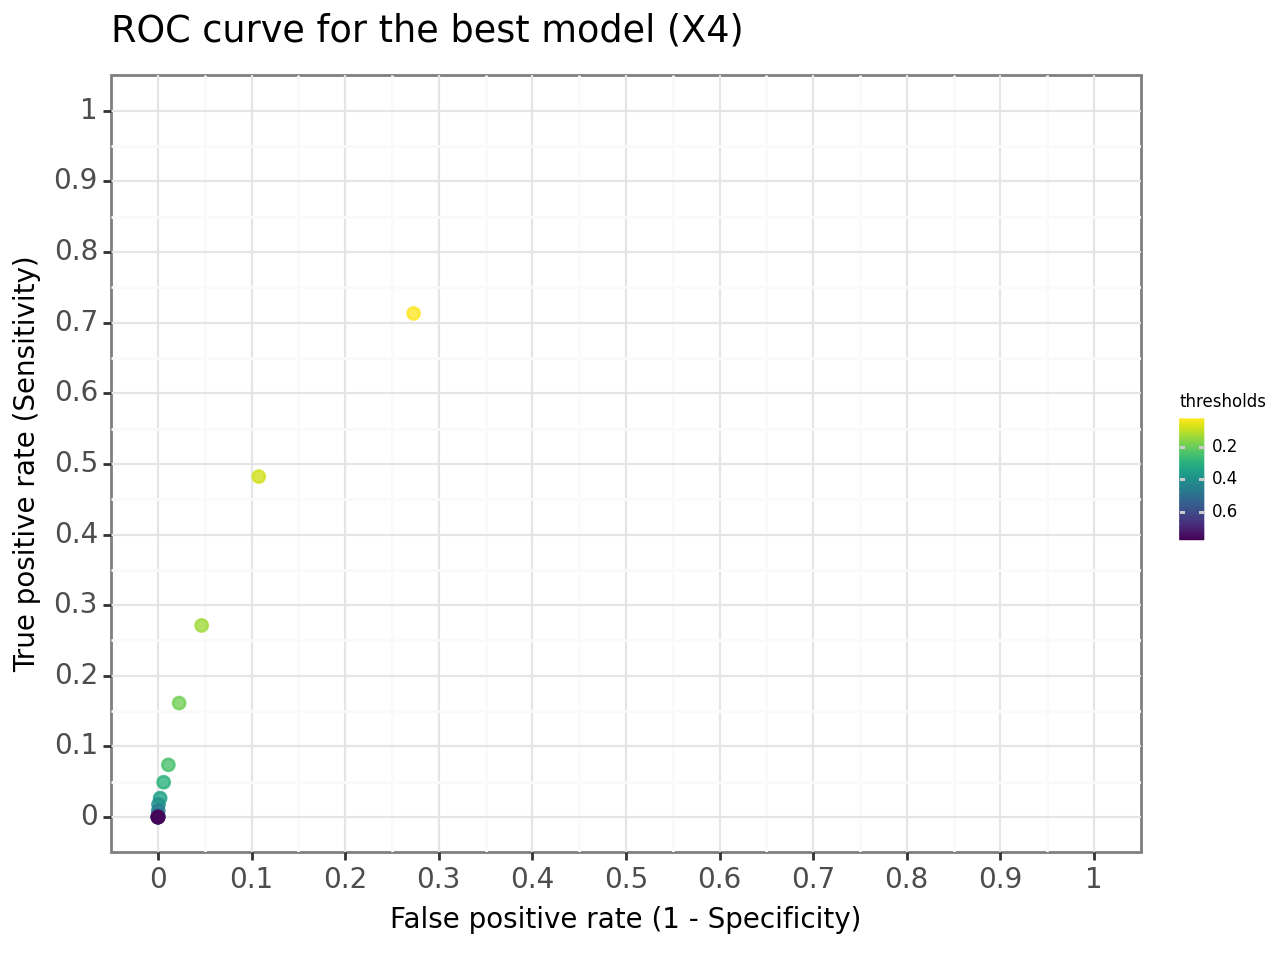

<Figure Size: (640 x 480)>

In [ ]:
ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
        + labs(
            x = "False positive rate (1 - Specificity)", 
            y = "True positive rate (Sensitivity)",
            title = 'ROC curve for the best model (X4)'
        )\
        + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
        + scale_x_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + scale_y_continuous(limits=(0,1), breaks = seq(0, 1.01, by = 0.1))\
        + theme_bw()\
        +theme(legend_position="right",
            axis_text=element_text(size=10),
            axis_title=element_text(size=10),
            legend_text = element_text(size = 6),
            legend_title = element_text(size = 6),
            legend_key_size=6)

In [ ]:
%matplotlib inline

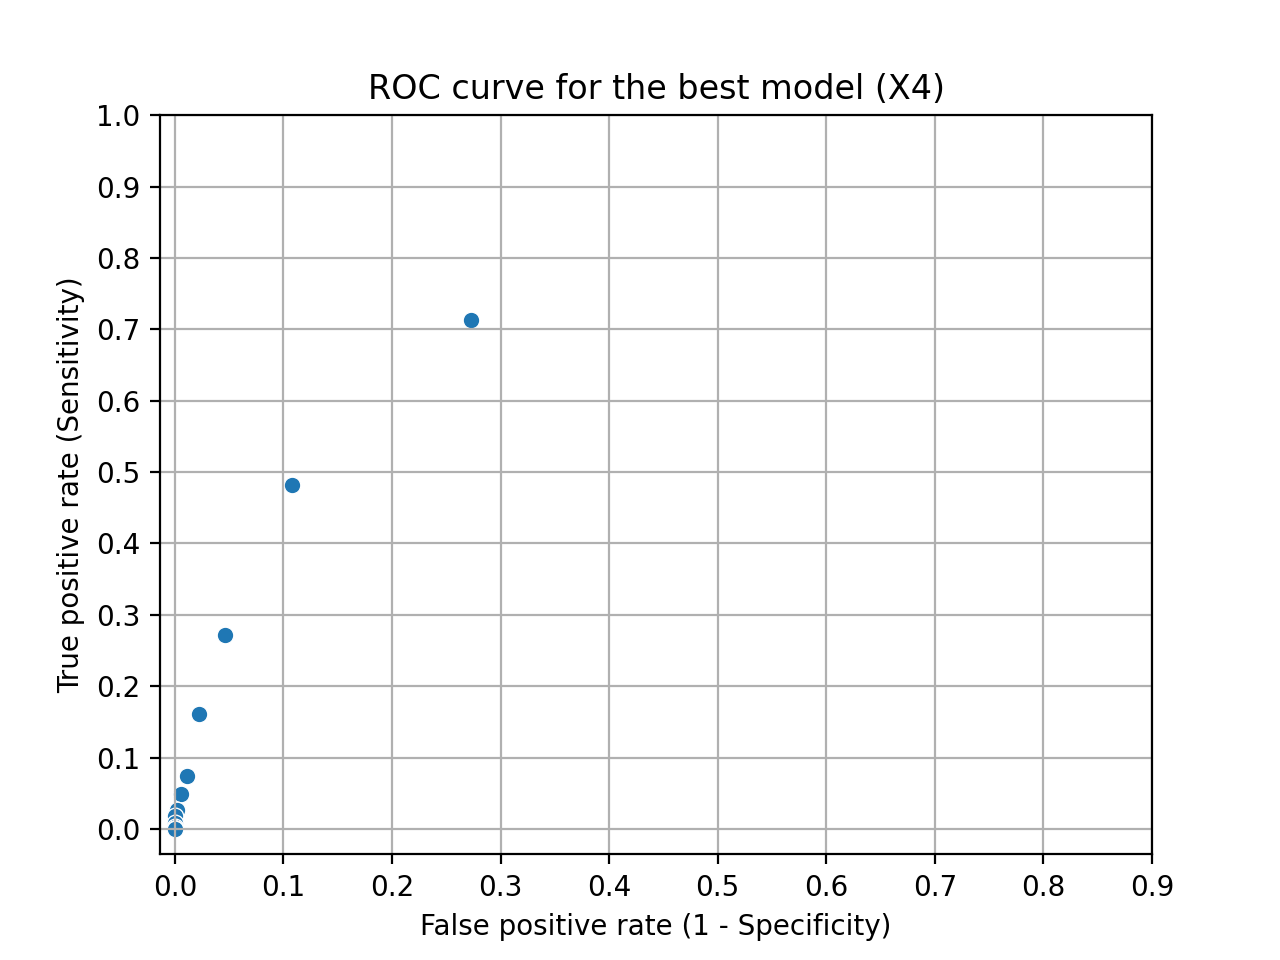

In [ ]:
ax = sns.scatterplot(
    data = tpr_fpr_for_thresholds,
    x = 'false_positive_rates', 
    y = 'true_positive_rates', 
    marker = 'o')
ax.set_title('ROC curve for the best model (X4)')
ax.set_xlabel("False positive rate (1 - Specificity)"), 
ax.set_ylabel("True positive rate (Sensitivity)")
ax.set_xticks([x/10 for x in range(0,10,1)])
ax.set_yticks([x/10 for x in range(0,11,1)])
ax.grid(True);

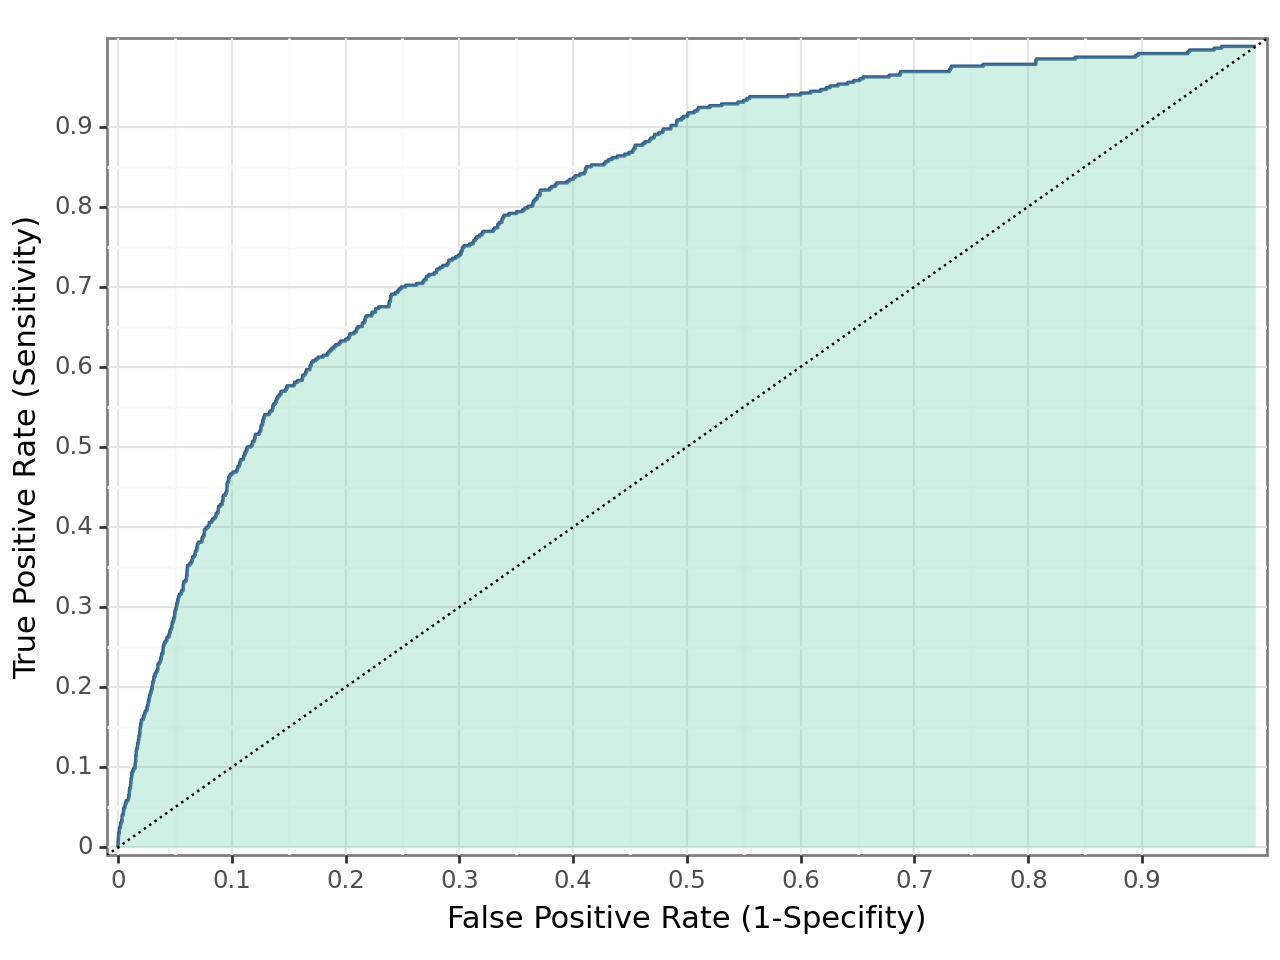

<Figure Size: (640 x 480)>

In [ ]:
create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_holdout, logit_predicted_probabilities_holdout)

In [ ]:
df_ = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds
})

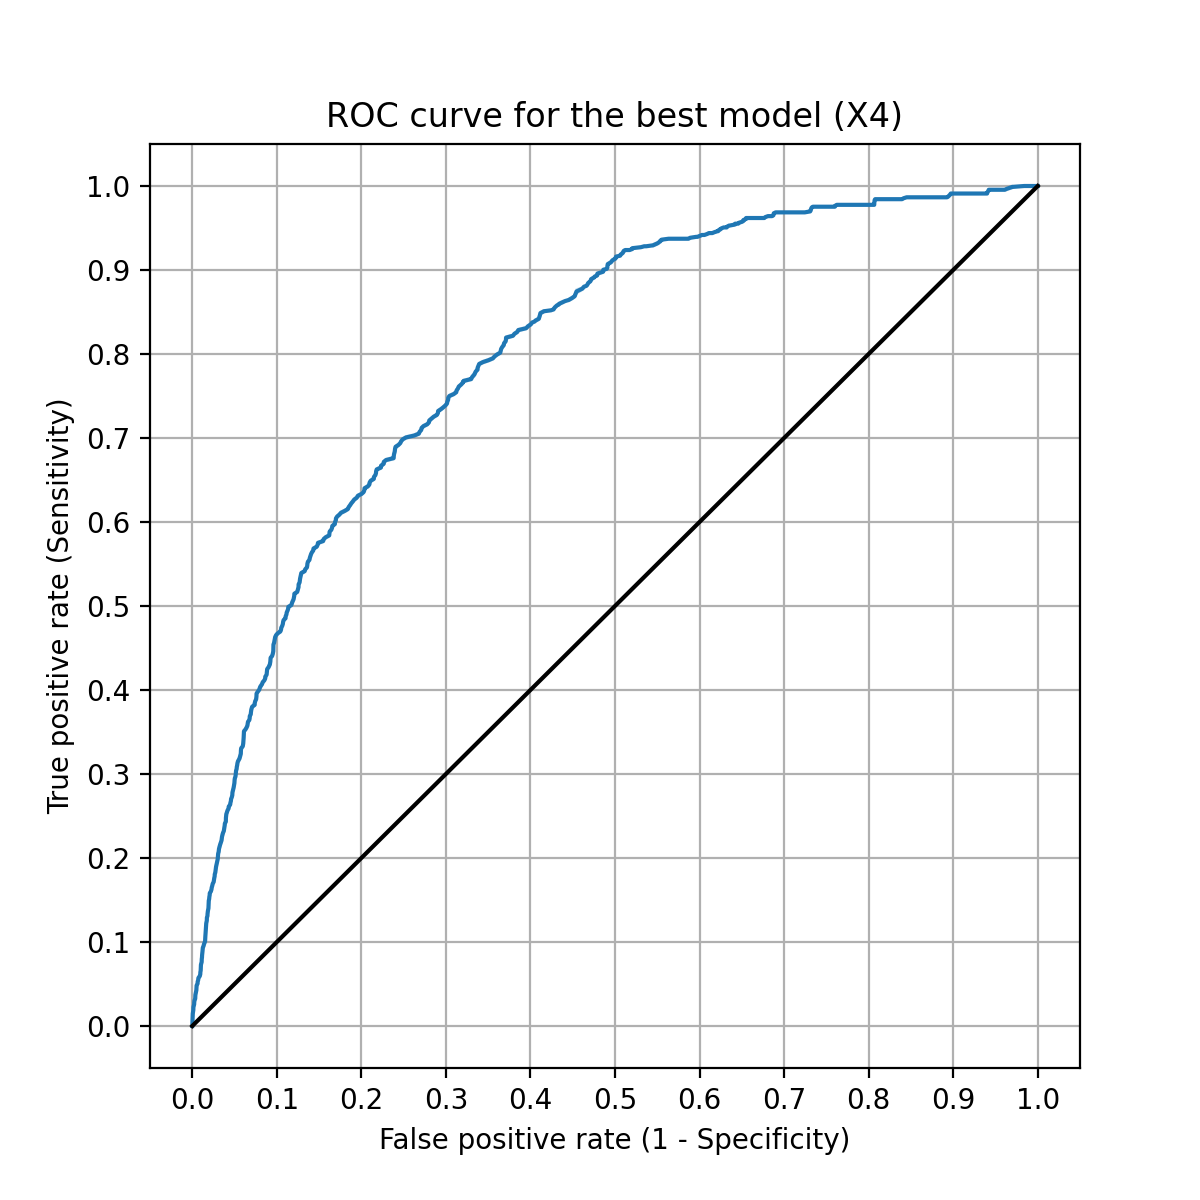

In [ ]:
plt.figure(figsize = (6,6))
ax = sns.lineplot(
    data = df_,
    x = fpr, 
    y = tpr)
ax.set_title('ROC curve for the best model (X4)')
ax.set_xlabel("False positive rate (1 - Specificity)"), 
ax.set_ylabel("True positive rate (Sensitivity)")
ax.set_xticks([x/10 for x in range(0,11,1)])
ax.set_yticks([x/10 for x in range(0,11,1)])
ax.plot(df_.fpr, df_.fpr, color = 'k')
ax.grid(True);

In [ ]:
logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0],' (no default): ',counts[0])
print(values[1],' (default): ',counts[1])

0  (no default):  10796
1  (default):  2


In [ ]:
cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
cm1 = pd.DataFrame(cm_object1, 
    index=['Actual no default', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm1

,Predicted no default,Predicted default
Actual no default,10351,1
Actual default,445,1


In [ ]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < 0.5, 0, 1)
cm_object1b = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm1b = pd.DataFrame(cm_object1b, 
    index=['Actual no default', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm1b

,Predicted no default,Predicted default
Actual no default,10351,1
Actual default,445,1


In [ ]:
print(f'FPR: {round(cm1b.iloc[0,1] / cm1b.iloc[0].sum(), 3)}')

FPR: 0.0


In [ ]:
mean_predicted_default_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_default_prob, 3)

0.045

In [ ]:
holdout_prediction = np.where(logit_predicted_probabilities_holdout < mean_predicted_default_prob, 0, 1)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm2 = pd.DataFrame(cm_object2, 
    index=['Actul no defaul', 'Actual default'], 
    columns=['Predicted no default', 'Predicted default'])
cm2

,Predicted no default,Predicted default
Actul no defaul,7221,3131
Actual default,114,332


In [ ]:
print(f'FPR: {round(cm2.iloc[0,1] / cm2.iloc[0].sum(), 3)}')

FPR: 0.302


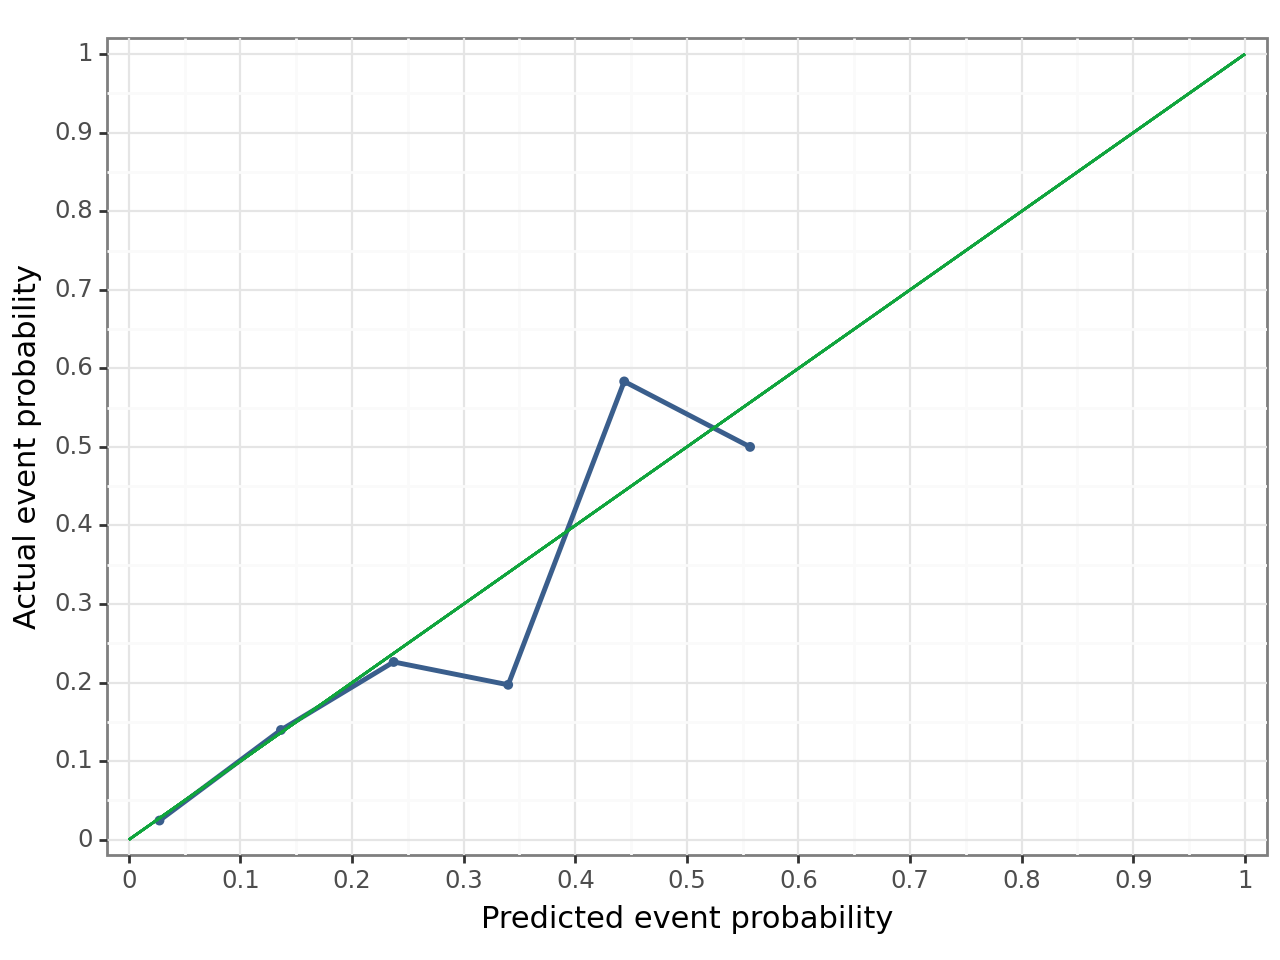

<Figure Size: (640 x 480)>

In [ ]:
holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
create_calibration_plot(
    holdout, 
    # file_name = "ch17-figure-1-logit-m4-calibration",
    prob_var='best_logit_no_loss_pred', 
    actual_var='default',
    y_lab="Actual event probability", 
    n_bins=10, 
    breaks=None)